In [1]:
import itertools
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.cluster import AffinityPropagation, DBSCAN
import sklearn.metrics.pairwise
sns.set_style('white')
plt.rcParams['image.cmap'] = 'viridis'
%matplotlib inline

In [2]:
PROPERTY_NAMES = ['Salt', 'Rostad', 'Flottig', 'Knaprig']
generate_palette = lambda n: sns.color_palette("Set1", n_colors=n, desat=.8)
MARKERS = ['o', 'v', 's', 'p', '^', 'h', '<']

In [3]:
def plot_pairs(data, max_cols=3, clusters=None):
    data = pd.DataFrame(data)
    colnames = data.columns
    rows = int(np.ceil(len(colnames) / max_cols))
    cols = min(max_cols, len(colnames))
    pairs = list(itertools.combinations(colnames, 2))
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    
    if clusters is None:
        clusters = [0] * len(data)        

    if isinstance(clusters, dict):
        clusters = pd.Series(clusters)
    if not isinstance(clusters, pd.Series):
        clusters = pd.Series(data=clusters, index=data.index)
    clusters = clusters[data.index]

    colors = generate_palette(len(clusters.unique()))
    
    for (propa, propb), ax in zip(pairs, axs.flat):
        for cluster, marker, color in zip(clusters.unique(), MARKERS, colors):
            d = data[clusters == cluster]
            ax.scatter(d[propa], d[propb], marker=marker, color=color, s=40)
            ax.set_xlabel(propa)
            ax.set_ylabel(propb)
            fig.tight_layout()

def sort_scores(scores, people_clusters=None, nut_clusters=None):
    sorted_scores = scores.copy()
    if people_clusters is not None:
        assert len(people_clusters) == scores.shape[0]
        sorted_scores = sorted_scores.iloc[np.argsort(people_clusters), :]
    if nut_clusters is not None:
        assert len(nut_clusters) == scores.shape[1]
        sorted_scores = sorted_scores.iloc[:, np.argsort(nut_clusters)]
    return sorted_scores

def plot_biclustering(scores, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.matrix.heatmap(sort_scores(scores, **kwargs), ax=ax)
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)
    return ax

## Simulate nuts and people

In [69]:
def nut_generator(clusters):
    cluster_names = list(clusters.keys())
    while True:
        name = np.random.choice(cluster_names)
        yield (name, clusters[name] + 0.2 * np.random.random(len(PROPERTY_NAMES)))

N = 18
M = 24
ng = nut_generator(
    {
        'more-is-more': [1., 1., 1., .1],
        'natural': [0., 0.1, 0.1, 0.4],
        'ok-but-too-salt': [0.8, 0.5, 0.5, .5],
        'dry-and-soft': [0.5, 0.5, 0.1, 0.2]
    }
)
nuts_clusters_data = [next(ng) for j in range(N)]
nuts_raw = (np.stack(list(zip(*nuts_clusters_data))[1]) * 5 + 1).round(2)

people_clusters_data = [next(ng) for j in range(M)]
people_raw = (np.stack(list(zip(*people_clusters_data))[1]) * 5 + 1).round()

nuts = pd.DataFrame(nuts_raw, columns=PROPERTY_NAMES, index=[i+1 for i in range(len(nuts_raw))])
scores = sklearn.metrics.pairwise_distances(people_raw, nuts_raw, metric='euclidean')
scores = pd.DataFrame(
    scores,
    index=['P{:02}'.format(i) for i in range(len(people_raw))],
    columns=['{:02}'.format(i) for i in range(len(nuts_raw))])

## Load real data

In [84]:
def load_data(paths):
    d = pd.concat(
        pd.DataFrame.from_csv(path, index_col=None, parse_dates=['Timestamp'])
        for path in paths)

    d = d.rename(
        columns={ ''
            'Din TBF': 'TBF',
            'Jordnötens nummer': 'Nöt',
            'Betygsätt totalupplevelsen': 'Betyg'
        })
    
    d['TBF'] = [v.upper() for v in d['TBF']]

    nuts = ['{:02}'.format(v) for v in d['Nöt']]
    d['Nöt'] = nuts
    
    def get_latest(d):
        return d.sort_values('Timestamp', ascending=False).iloc[0]

    
    timestamps = d.groupby(['TBF', 'Nöt']).apply(get_latest).reset_index(drop=True).set_index('Timestamp').index
    return d.set_index('Timestamp').loc[timestamps, :].reset_index()

all_data = load_data(['abc', 'abc3', 'Untitled form.csv'])
all_data.head()

,Timestamp,TBF,Nöt,Salt,Knaprig,Rostad,Flottig,Betyg,Kommentar
0,2016-09-24 11:38:24,ATG,04,4,4,4,4,4,4
1,2016-09-17 00:24:13,ATG,07,1,1,1,1,1,aoeu
2,2016-09-17 00:23:34,ATG,11,3,5,3,6,4,NaN
3,2016-09-17 00:19:11,PPA,06,6,4,5,3,5,NaN
4,2016-09-17 00:11:19,PSI,02,3,6,3,6,1,NaN


## Rename nuts

In [85]:
import json
with open('num_to_letter.json', 'r') as f:
    num_to_letter = json.load(f)

In [86]:
all_data.replace({'Nöt': num_to_letter}, inplace=True)
all_data.head()

,Timestamp,TBF,Nöt,Salt,Knaprig,Rostad,Flottig,Betyg,Kommentar
0,2016-09-24 11:38:24,ATG,R,4,4,4,4,4,4
1,2016-09-17 00:24:13,ATG,Q,1,1,1,1,1,aoeu
2,2016-09-17 00:23:34,ATG,A,3,5,3,6,4,NaN
3,2016-09-17 00:19:11,PPA,Z,6,4,5,3,5,NaN
4,2016-09-17 00:11:19,PSI,U,3,6,3,6,1,NaN


In [88]:
#letter_to_name = pd.read_csv('letter_to_name.csv')['Namn']
letter_to_name = pd.Series({'R': 'Estrella', 'Q': 'arne', 'K': 'Fram', 'U': 'Hemodlade'})
all_data.replace({'Nöt': letter_to_name}, inplace=True)
all_data.head()

,Timestamp,TBF,Nöt,Salt,Knaprig,Rostad,Flottig,Betyg,Kommentar
0,2016-09-24 11:38:24,ATG,Estrella,4,4,4,4,4,4
1,2016-09-17 00:24:13,ATG,arne,1,1,1,1,1,aoeu
2,2016-09-17 00:23:34,ATG,A,3,5,3,6,4,NaN
3,2016-09-17 00:19:11,PPA,Z,6,4,5,3,5,NaN
4,2016-09-17 00:11:19,PSI,Hemodlade,3,6,3,6,1,NaN


## Compute scores

In [89]:
raw_scores = all_data.set_index(['TBF', 'Nöt'])['Betyg'].unstack()
scores = raw_scores.apply(lambda row: row.where(row.notnull(), raw_scores.mean()), axis=1)
nuts = all_data.groupby('Nöt')[PROPERTY_NAMES].mean()

## Inspect the data

In [90]:
all_data.head()

,Timestamp,TBF,Nöt,Salt,Knaprig,Rostad,Flottig,Betyg,Kommentar
0,2016-09-24 11:38:24,ATG,Estrella,4,4,4,4,4,4
1,2016-09-17 00:24:13,ATG,arne,1,1,1,1,1,aoeu
2,2016-09-17 00:23:34,ATG,A,3,5,3,6,4,NaN
3,2016-09-17 00:19:11,PPA,Z,6,4,5,3,5,NaN
4,2016-09-17 00:11:19,PSI,Hemodlade,3,6,3,6,1,NaN


In [91]:
raw_scores

Nöt,A,D,Estrella,Fram,G,Hemodlade,I,J,Z,arne
TBF,,,,,,,,,,
ATG,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
PPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
PSI,NaN,6.0,NaN,NaN,7.0,1.0,6.0,5.0,NaN,NaN
VPK,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WWW,NaN,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
scores

Nöt,A,D,Estrella,Fram,G,Hemodlade,I,J,Z,arne
TBF,,,,,,,,,,
ATG,4.0,5.5,4.0,1.0,7.0,1.0,6.0,5.0,5.0,1.0
PPA,4.0,5.5,4.0,1.0,7.0,1.0,6.0,5.0,5.0,1.0
PSI,4.0,6.0,4.0,1.0,7.0,1.0,6.0,5.0,5.0,1.0
VPK,4.0,5.0,4.0,1.0,7.0,1.0,6.0,5.0,5.0,1.0
WWW,4.0,5.5,4.0,1.0,7.0,1.0,6.0,5.0,5.0,1.0


In [93]:
nuts

,Salt,Rostad,Flottig,Knaprig
Nöt,,,,
A,3.0,3.0,6.0,5.0
D,4.5,4.5,3.5,4.0
Estrella,3.5,3.5,3.5,3.5
Fram,7.0,5.0,4.0,6.0
G,5.0,5.0,3.0,2.0
Hemodlade,3.0,3.0,6.0,6.0
I,4.0,5.0,7.0,5.0
J,4.0,5.0,3.0,2.0
Z,6.0,5.0,3.0,4.0


In [94]:
scores.round(2)

Nöt,A,D,Estrella,Fram,G,Hemodlade,I,J,Z,arne
TBF,,,,,,,,,,
ATG,4.0,5.5,4.0,1.0,7.0,1.0,6.0,5.0,5.0,1.0
PPA,4.0,5.5,4.0,1.0,7.0,1.0,6.0,5.0,5.0,1.0
PSI,4.0,6.0,4.0,1.0,7.0,1.0,6.0,5.0,5.0,1.0
VPK,4.0,5.0,4.0,1.0,7.0,1.0,6.0,5.0,5.0,1.0
WWW,4.0,5.5,4.0,1.0,7.0,1.0,6.0,5.0,5.0,1.0


## Compute principal components

In [99]:
pc_names = ['PC{}'.format(i + 1) for i in range(len(PROPERTY_NAMES))]
pcs = pd.DataFrame(
    sklearn.decomposition.PCA(n_components=len(PROPERTY_NAMES)).fit_transform(nuts[PROPERTY_NAMES]),
    columns=pc_names,
    index=nuts.index)
for col in pcs.columns:
    nuts[col] = pcs[col]

## Eyeball the nut properties

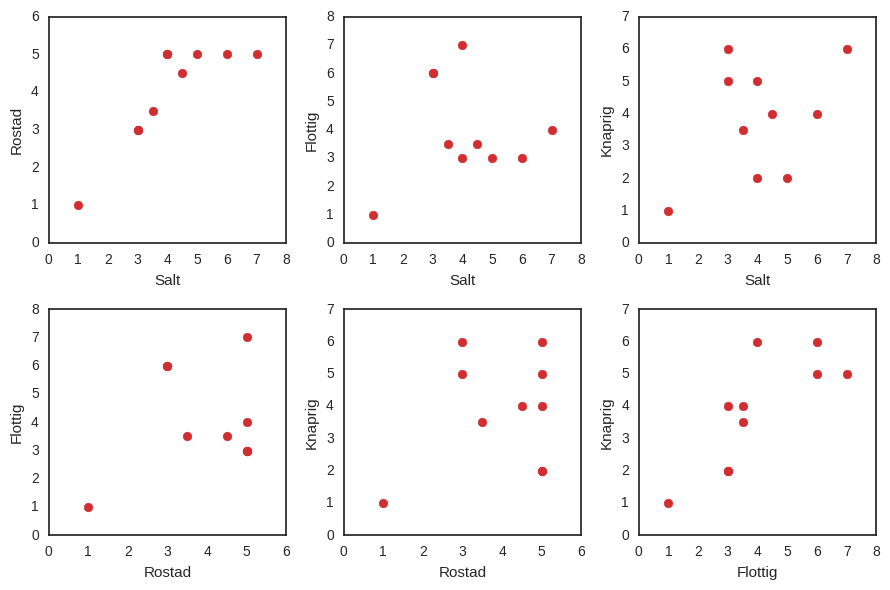

In [100]:
properties = PROPERTY_NAMES
# properties = pc_names
plot_pairs(nuts[properties])

## Try to find clusters of nut properties

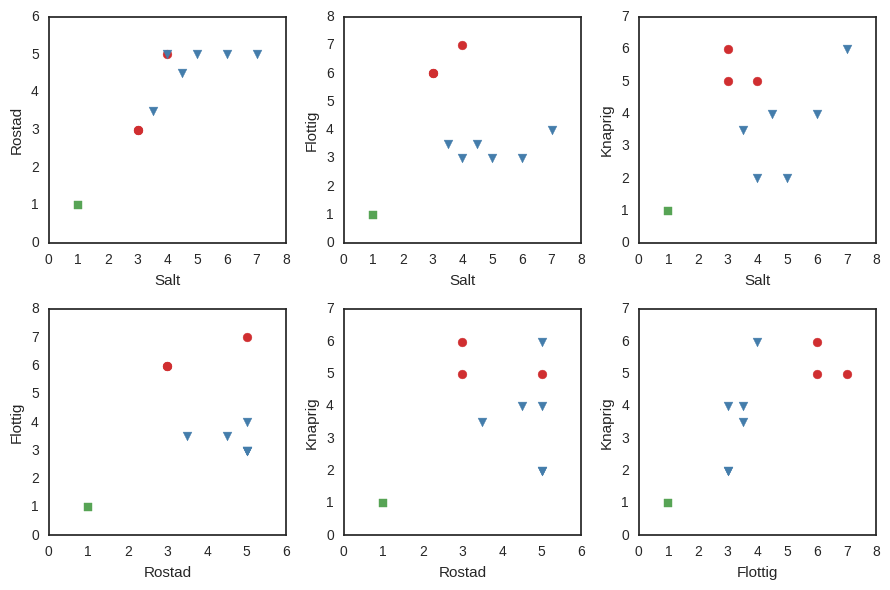

In [101]:
clustering_algorithm = AffinityPropagation()
#clustering_algorithm = DBSCAN(eps=0.3, min_samples=3)

clustering_algorithm.fit(nuts[properties])
clusters = clustering_algorithm.labels_
plot_pairs(nuts[properties], clusters=clusters)

## Try spectral biclustering

In [102]:
num_people_clusters = 4
num_nut_clusters = 4
m = SpectralBiclustering(n_clusters=(num_people_clusters, num_nut_clusters))
# m = SpectralBiclustering(n_clusters=(num_people_clusters, num_nut_clusters), method='log')
m.fit(scores)

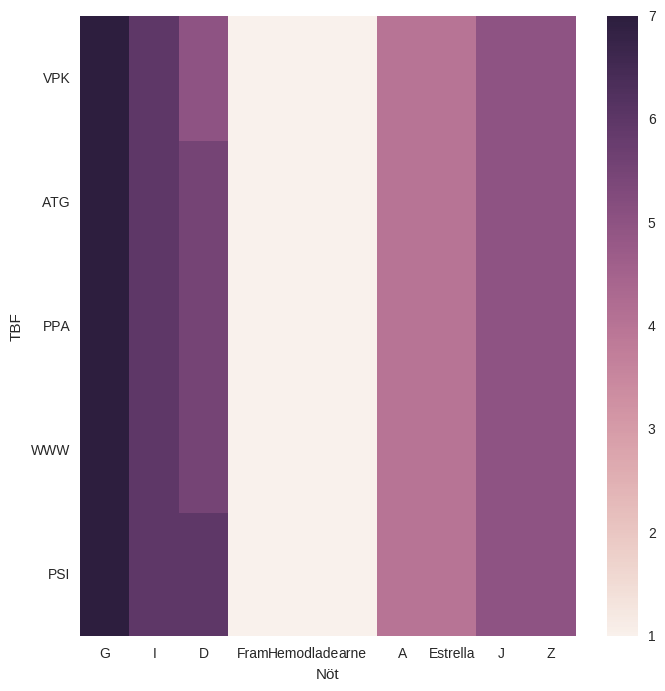

In [105]:
plot_biclustering(scores, nut_clusters=m.column_labels_, people_clusters=m.row_labels_);

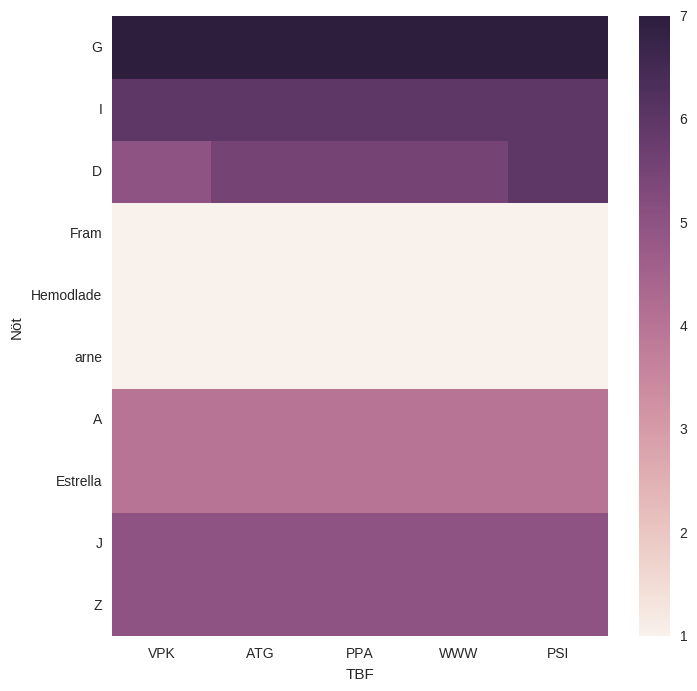

In [106]:
plot_biclustering(scores.T, nut_clusters=m.row_labels_, people_clusters=m.column_labels_);

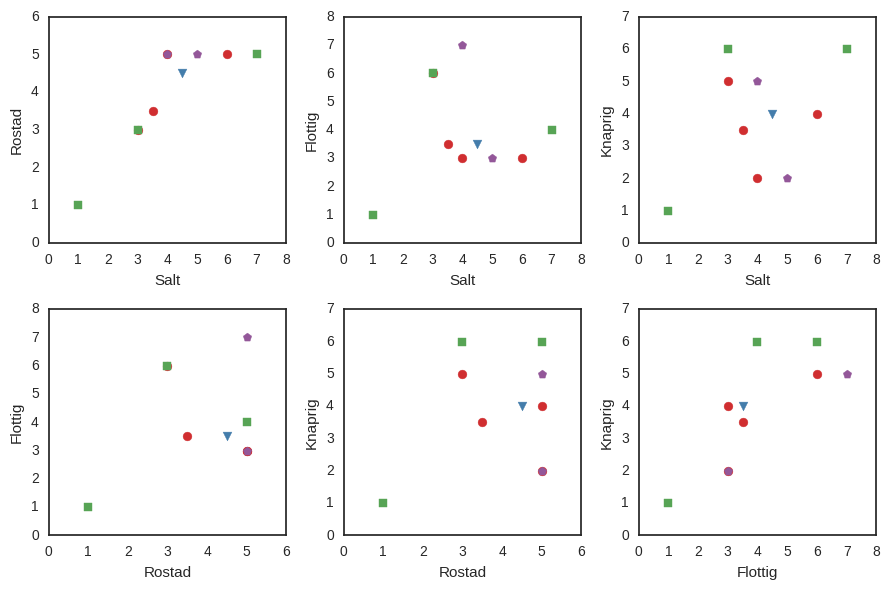

In [107]:
plot_pairs(nuts[properties], clusters=m.column_labels_)